## Optimized Boolean Network Inference

In [155]:
# Required Libraries

import itertools
import pandas as pd
import sympy as sp
import re
import random
import csv
import sys
import networkx as nx
import numpy as np
import os
import matplotlib.pyplot as plt
from lib import canalizing_function_toolbox as cft
from lib import load_database as db
from concurrent.futures import ProcessPoolExecutor, as_completed
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import _tree
from sklearn.metrics import mutual_info_score
import io
import contextlib
from itertools import product
from sympy.logic.boolalg import simplify_logic


# Definitions & Hyperparameters

INPUT_DIR = "./inputs"
OUTPUT_DIR = "./outputs"
INPUT_MODELS_DIR = "./inputs/models"
OUTPUT_MODELS_DIR = "./outputs/models"
INPUT_STATE_TRANSITIONS_DIR = "./inputs/state_transitions"
OUTPUT_STATE_TRANSITIONS_DIR = "./outputs/state_transitions"

NUM_INITIAL_STATES = 60

### Loading and Simulating a Boolean Network

In [156]:
def load_rules(file_path):
    with open(file_path, "r") as file:
        lines = file.readlines()

    rules = [line.strip() for line in lines if '=' in line]
    rules_dict = {}
    for rule in rules:
        var, expr = rule.split('=', 1)
        var = var.strip()
        expr = expr.strip()
        expr = expr.replace('AND', '&').replace('OR', '|').replace('NOT', '~')
        expr = re.sub(r'\b(\w+)\b', r'symbols["\1"]', expr)
        rules_dict[var] = expr

    return rules_dict

def prepare_symbols_and_functions(rules_dict):
    all_names = set(rules_dict.keys())
    for expr in rules_dict.values():
        tokens = re.findall(r'symbols\["(\w+)"\]', expr)
        all_names.update(tokens)

    symbols = {name: sp.Symbol(name) for name in all_names}
    update_funcs = {
        node: sp.sympify(expr, locals={'symbols': symbols})
        for node, expr in rules_dict.items()
    }

    return symbols, update_funcs

# def state_to_str(state):
#     return ''.join(str(b) for b in state)

def next_state(current_state, node_names, node2idx, symbols, fixed_nodes, update_funcs):
    env = {symbols[node]: current_state[node2idx[node]] for node in node_names}
    next_state = []
    for node in node_names:
        if node in fixed_nodes:
            next_state.append(fixed_nodes[node])
        elif node in update_funcs:
            val = int(bool(update_funcs[node].subs(env)))
            next_state.append(val)
        else:
            next_state.append(current_state[node2idx[node]])
    return tuple(next_state)

def generate_initial_states(node_names, fixed_nodes, num_samples=NUM_INITIAL_STATES):
    n = len(node_names)
    all_possible = 2 ** n

    if num_samples >= all_possible:
        # Generate all possible 2^n states
        all_states = list(itertools.product([0, 1], repeat=n))
        # Apply fixed node constraints
        initial_states = []
        for state in all_states:
            valid = True
            for i, node in enumerate(node_names):
                if node in fixed_nodes and state[i] != fixed_nodes[node]:
                    valid = False
                    break
            if valid:
                initial_states.append(state)
        return initial_states

    # Otherwise, sample randomly without repetition
    generated_states = set()
    initial_states = []

    while len(initial_states) < num_samples:
        state = []
        for i, node in enumerate(node_names):
            if node in fixed_nodes:
                state.append(fixed_nodes[node])
            else:
                state.append(random.randint(0, 1))
        state_tuple = tuple(state)
        if state_tuple not in generated_states:
            generated_states.add(state_tuple)
            initial_states.append(state_tuple)

    return initial_states

def calculate_next_state(current_state, node_names, fixed_nodes, update_funcs, symbols, node2idx):
    """Calculate next network state using Boolean rules"""
    env = {symbols[node]: current_state[node2idx[node]] for node in node_names}
    return tuple(
        fixed_nodes[node] if node in fixed_nodes
        else int(bool(update_funcs[node].subs(env))) if node in update_funcs
        else current_state[node2idx[node]]
        for node in node_names
    )

def simulate_from_initial(init_state, node_names, node2idx, symbols, fixed_nodes, update_funcs):
    """Run single simulation from initial state"""
    visited = []
    current = init_state
    transitions = []
    status = "unknown"
    cycle_length = 0

    for step in range(1000):
        current_str = ''.join(map(str, current))
        if current_str in visited:
            idx = visited.index(current_str)
            status = "steady state" if idx == len(visited)-1 else "limit cycle"
            cycle_length = len(visited) - idx
            break
            
        visited.append(current_str)
        next_state = calculate_next_state(current, node_names, fixed_nodes, update_funcs, symbols, node2idx)
        transitions.append((current_str, ''.join(map(str, next_state))))
        current = next_state

    if status == "unknown":
        status = "max steps reached"

    return {
        "transitions": transitions,
        "status": status,
        "cycle_length": cycle_length,
        "steps": len(transitions)
    }

def run_simulations(initial_states, output_file, node_names, node2idx, symbols, fixed_nodes, update_funcs):
    with open(output_file, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["from_state", "to_state"])

    with ProcessPoolExecutor() as executor:
        futures = [
            executor.submit(simulate_from_initial, init, node_names, node2idx, symbols, fixed_nodes, update_funcs)
            for init in initial_states
        ]

        for i, future in enumerate(as_completed(futures), 1):
            result = future.result()
            with open(output_file, "a", newline="") as f:
                writer = csv.writer(f)
                writer.writerows(result["transitions"])

            print(f"Run {i}/{len(initial_states)}: {result['status']} | "
                  f"steps = {result['steps']}, "
                  f"cycle_length = {result['cycle_length']}")


In [157]:
rules_dict = load_rules(INPUT_MODELS_DIR + "/input3.txt")
# print("Rules after ReGex Matching")
# print(rules_dict)
# print()

symbols, update_funcs = prepare_symbols_and_functions(rules_dict)
# print(symbols)
# print(update_funcs)

fixed_nodes = {
    # "TNF": 1,
    # "GF": 1
}

node_names = sorted(list(symbols.keys()))
#print(node_names)
non_fixed_nodes = [n for n in node_names if n not in fixed_nodes]

idx2node = {i: node for i, node in enumerate(node_names)}
node2idx = {node: i for i, node in idx2node.items()}

initial_states = generate_initial_states(node_names, fixed_nodes, num_samples=NUM_INITIAL_STATES)
with open(INPUT_STATE_TRANSITIONS_DIR + "/init3.txt", "w") as f:
        for state in initial_states:
            f.write(''.join(map(str, state)) + "\n")

run_simulations(initial_states, INPUT_STATE_TRANSITIONS_DIR + "/st3.csv", node_names, node2idx, symbols, fixed_nodes, update_funcs)

Run 1/60: steady state | steps = 3, cycle_length = 1
Run 2/60: steady state | steps = 2, cycle_length = 1
Run 3/60: steady state | steps = 2, cycle_length = 1
Run 4/60: steady state | steps = 2, cycle_length = 1
Run 5/60: steady state | steps = 5, cycle_length = 1
Run 6/60: steady state | steps = 4, cycle_length = 1
Run 7/60: steady state | steps = 5, cycle_length = 1
Run 8/60: steady state | steps = 6, cycle_length = 1
Run 9/60: steady state | steps = 5, cycle_length = 1
Run 10/60: limit cycle | steps = 3, cycle_length = 2
Run 11/60: steady state | steps = 5, cycle_length = 1
Run 12/60: steady state | steps = 8, cycle_length = 1
Run 13/60: steady state | steps = 7, cycle_length = 1
Run 14/60: steady state | steps = 4, cycle_length = 1
Run 15/60: steady state | steps = 2, cycle_length = 1
Run 16/60: steady state | steps = 8, cycle_length = 1
Run 17/60: steady state | steps = 7, cycle_length = 1
Run 18/60: steady state | steps = 7, cycle_length = 1
Run 19/60: steady state | steps = 9, c

### Decision Tree Inference

In [158]:
def load_transitions(csv_file):
    transitions = set()
    with open(csv_file, "r", newline="") as f:
        reader = csv.DictReader(f)
        if reader.fieldnames != ["from_state", "to_state"]:
            print(f"Error: Unexpected columns in {csv_file}. Expected ['from_state', 'to_state'].")
            sys.exit(1)
        for row in reader:
            transitions.add((row["from_state"].strip(), row["to_state"].strip()))
    return transitions

def compare_transition_files(file1, file2):
    """Compare two transition files and show difference statistics"""
    def load_transitions(filename):
        with open(filename) as f:
            return {tuple(line.strip().split(',')) for line in f}
    
    transitions1 = load_transitions(file1)
    transitions2 = load_transitions(file2)
    
    common = transitions1 & transitions2
    unique_to_1 = transitions1 - transitions2
    unique_to_2 = transitions2 - transitions1
    
    print(f"Comparison between {file1} and {file2}:")
    print(f"Total transitions in {file1}: {len(transitions1):,}")
    print(f"Total transitions in {file2}: {len(transitions2):,}")
    print(f"\nCommon transitions: {len(common):,}")
    print(f"Unique to {file1}: {len(unique_to_1):,} ({len(unique_to_1)/len(transitions1):.1%})")
    print(f"Unique to {file2}: {len(unique_to_2):,} ({len(unique_to_2)/len(transitions2):.1%})")
    print(f"\nTotal discrepancies: {len(unique_to_1)+len(unique_to_2):,}")
    
    if len(unique_to_1) + len(unique_to_2) == 0:
        print("\nFiles are identical")
    else:
        print("\nFiles differ significantly")

    return len(common)*100/(len(transitions1)+len(transitions2)-len(common))

def extract_boolean_rule(tree_model, feature_names):
    """
    Convert trained DecisionTreeClassifier to Boolean expression
    Returns: String representing logical rule
    """
    tree = tree_model.tree_
    node_features = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree.feature
    ]
    
    rule_paths = []

    def depth_first_search(node, current_condition):
        if tree.feature[node] != _tree.TREE_UNDEFINED:
            feat_name = node_features[node]
            # Left branch (feature = 0)
            left_cond = current_condition + [f"~{feat_name}"]
            depth_first_search(tree.children_left[node], left_cond)
            # Right branch (feature = 1)
            right_cond = current_condition + [feat_name]
            depth_first_search(tree.children_right[node], right_cond)
        else:
            # Only consider paths leading to class 1
            class_prob = tree.value[node][0]
            if len(class_prob) == 1:  # Binary case
                predicted_class = 0
            else:
                predicted_class = int(class_prob[1] > class_prob[0])
                
            if predicted_class == 1:
                rule_paths.append(current_condition)

    depth_first_search(0, [])
    
    if not rule_paths:
        return "False"
    return " OR ".join(["(" + " AND ".join(path) + ")" for path in rule_paths])

def unpack_bits(bitstring):
    """Convert binary string or int to list of integers"""
    return [int(bit) for bit in str(bitstring)]

def infer_boolean_network(input_csv_path, output_txt_path, node_names, tree_params=None):
    import pandas as pd
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.tree import _tree
    
    if tree_params is None:
        tree_params = {
            'criterion': 'entropy',
            'max_depth': 3,
            'min_samples_leaf': 10,
            'random_state': 42
        }

    # --- Load transition data ---
    transition_df = pd.read_csv(input_csv_path, dtype=str)

    # --- Prepare feature and target arrays ---
    X = transition_df["from_state"].apply(unpack_bits)
    y = transition_df["to_state"].apply(unpack_bits)

    # --- Create DataFrames ---
    X_df = pd.DataFrame(X.tolist(), columns=node_names)
    y_df = pd.DataFrame(y.tolist(), columns=node_names)

    # --- Train Decision Trees ---
    inferred_rules = {}
    for target_gene in node_names:
        clf = DecisionTreeClassifier(**tree_params)
        clf.fit(X_df, y_df[target_gene])
        rule = extract_boolean_rule(clf, node_names)

        # Replace "~" with "NOT " so we never see the tilde in the output:
        rule = rule.replace("~", "NOT ")

        inferred_rules[target_gene] = rule or "No rule detected"

    # --- Write rules to file ---
    with open(output_txt_path, "w") as f:
        for gene, rule in inferred_rules.items():
            f.write(f"{gene} = {rule}\n")

    print(f"\nSuccessfully wrote inferred network to '{output_txt_path}'")


In [159]:
infer_boolean_network(
    input_csv_path = INPUT_STATE_TRANSITIONS_DIR + "/st3.csv",
    output_txt_path = OUTPUT_MODELS_DIR + "/output3.txt",
    node_names = node_names
)



Successfully wrote inferred network to './outputs/models/output3.txt'


### Testing on same initial states (DT)

In [162]:
# test on same initial states

initial_states = []
with open(INPUT_STATE_TRANSITIONS_DIR + "/init3.txt", 'r') as file:
    initial_states = [line.strip() for line in file]

rules_dict = load_rules(OUTPUT_MODELS_DIR + "/output3.txt")

symbols, update_funcs = prepare_symbols_and_functions(rules_dict)

run_simulations(initial_states, OUTPUT_STATE_TRANSITIONS_DIR + "/st3.csv", node_names, node2idx, symbols, fixed_nodes, update_funcs)

print("Accuracy: " + str(compare_transition_files(INPUT_STATE_TRANSITIONS_DIR + "/st3.csv", OUTPUT_STATE_TRANSITIONS_DIR + "/st3.csv")))

Run 1/60: steady state | steps = 2, cycle_length = 1
Run 2/60: steady state | steps = 2, cycle_length = 1
Run 3/60: steady state | steps = 3, cycle_length = 1
Run 4/60: steady state | steps = 3, cycle_length = 1
Run 5/60: steady state | steps = 4, cycle_length = 1
Run 6/60: steady state | steps = 5, cycle_length = 1
Run 7/60: steady state | steps = 3, cycle_length = 1
Run 8/60: steady state | steps = 6, cycle_length = 1
Run 9/60: steady state | steps = 7, cycle_length = 1
Run 10/60: steady state | steps = 9, cycle_length = 1
Run 11/60: steady state | steps = 8, cycle_length = 1
Run 12/60: steady state | steps = 5, cycle_length = 1
Run 13/60: steady state | steps = 7, cycle_length = 1
Run 14/60: steady state | steps = 7, cycle_length = 1
Run 15/60: steady state | steps = 8, cycle_length = 1
Run 16/60: limit cycle | steps = 3, cycle_length = 2
Run 17/60: steady state | steps = 4, cycle_length = 1
Run 18/60: steady state | steps = 7, cycle_length = 1
Run 19/60: steady state | steps = 2, c

### Testing on different initial states (DT)

In [163]:
initial_states = generate_initial_states(node_names, fixed_nodes, num_samples=NUM_INITIAL_STATES)
run_simulations(initial_states, OUTPUT_STATE_TRANSITIONS_DIR + "/st3.csv", node_names, node2idx, symbols, fixed_nodes, update_funcs)
print("Accuracy: " + str(compare_transition_files(INPUT_STATE_TRANSITIONS_DIR + "/st3.csv", OUTPUT_STATE_TRANSITIONS_DIR + "/st3.csv")))

Run 1/60: steady state | steps = 4, cycle_length = 1
Run 2/60: steady state | steps = 2, cycle_length = 1
Run 3/60: steady state | steps = 4, cycle_length = 1
Run 4/60: steady state | steps = 4, cycle_length = 1
Run 5/60: steady state | steps = 3, cycle_length = 1
Run 6/60: steady state | steps = 7, cycle_length = 1
Run 7/60: steady state | steps = 5, cycle_length = 1
Run 8/60: steady state | steps = 2, cycle_length = 1
Run 9/60: steady state | steps = 6, cycle_length = 1
Run 10/60: steady state | steps = 7, cycle_length = 1
Run 11/60: steady state | steps = 5, cycle_length = 1
Run 12/60: steady state | steps = 5, cycle_length = 1
Run 13/60: steady state | steps = 5, cycle_length = 1
Run 14/60: steady state | steps = 8, cycle_length = 1
Run 15/60: steady state | steps = 3, cycle_length = 1
Run 16/60: steady state | steps = 7, cycle_length = 1
Run 17/60: steady state | steps = 3, cycle_length = 1
Run 18/60: steady state | steps = 7, cycle_length = 1
Run 19/60: steady state | steps = 7, 

### Analysis by changing no. of initial states (DT)

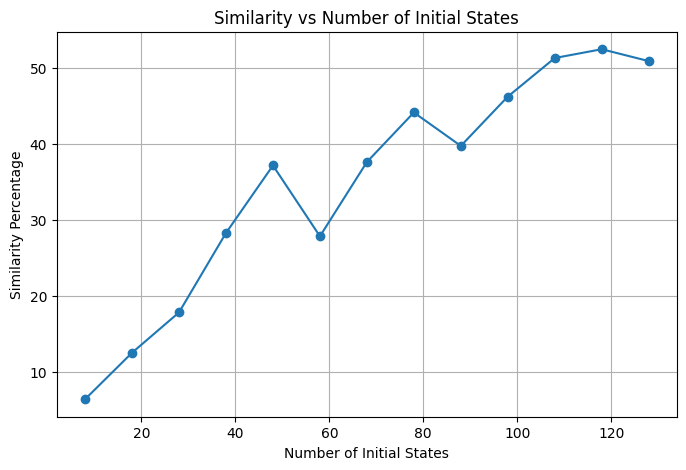

In [180]:
temp = NUM_INITIAL_STATES

similarity_percents = []
initial_states_list = []

with contextlib.redirect_stdout(io.StringIO()):
    for NUM_INITIAL_STATES in range(8, 129, 10):
        initial_states = generate_initial_states(node_names, fixed_nodes, num_samples=NUM_INITIAL_STATES)

        rules_dict = load_rules(INPUT_MODELS_DIR + "/input3.txt")

        symbols, update_funcs = prepare_symbols_and_functions(rules_dict)

        run_simulations(
            initial_states,
            INPUT_STATE_TRANSITIONS_DIR + "/st3.csv",
            node_names,
            node2idx,
            symbols,
            fixed_nodes,
            update_funcs
        )

        infer_boolean_network(
            input_csv_path = INPUT_STATE_TRANSITIONS_DIR + "/st3.csv",
            output_txt_path = OUTPUT_MODELS_DIR + "/output3.txt",
            node_names = node_names
        )

        rules_dict = load_rules(OUTPUT_MODELS_DIR + "/output3.txt")

        symbols, update_funcs = prepare_symbols_and_functions(rules_dict)

        initial_states2 = generate_initial_states(node_names, fixed_nodes, num_samples=NUM_INITIAL_STATES)

        run_simulations(
            initial_states2,
            OUTPUT_STATE_TRANSITIONS_DIR + "/st3.csv",
            node_names,
            node2idx,
            symbols,
            fixed_nodes,
            update_funcs
        )

        similarity_percent = compare_transition_files(
            INPUT_STATE_TRANSITIONS_DIR + "/st3.csv",
            OUTPUT_STATE_TRANSITIONS_DIR + "/st3.csv"
        )

        initial_states_list.append(NUM_INITIAL_STATES)
        similarity_percents.append(similarity_percent)

# Plot the results
plt.figure(figsize=(8, 5))
plt.plot(initial_states_list, similarity_percents, marker='o')
plt.xlabel('Number of Initial States')
plt.ylabel('Similarity Percentage')
plt.title('Similarity vs Number of Initial States')
plt.grid(True)
plt.show()

NUM_INITIAL_STATES = temp


### MIBNI Inference (State of the Art Method)

In [181]:
def unpack_bits(bitstring):
    """Convert binary string or int to list of integers"""
    return [int(b) for b in str(bitstring).strip()]

def compute_pairwise_mi(X_df, y_series):
    """Compute mutual information between each column of X_df and y_series."""
    mi = {}
    for col in X_df.columns:
        mi[col] = mutual_info_score(X_df[col], y_series)
    return mi

def greedy_regulator_selection(X_df, y_series, max_regulators=3, mi_stop_thresh=1e-3):
    """
    Greedy selection of regulators maximizing I({S ∪ {j}}; y)
    Stops when adding any new regulator yields < mi_stop_thresh gain.
    """
    selected = []
    current_mi = 0.0

    # Precompute pairwise MI
    pair_mi = compute_pairwise_mi(X_df, y_series)
    # pick the best single regulator
    best1 = max(pair_mi, key=pair_mi.get)
    selected.append(best1)
    current_mi = pair_mi[best1]

    # greedy add
    while len(selected) < max_regulators:
        best_gain = 0
        best_candidate = None
        for cand in X_df.columns.difference(selected):
            # compute joint MI by discretizing the joint variable
            # build an integer code for current + candidate
            joint = X_df[selected + [cand]].astype(str).agg(''.join, axis=1)
            gain = mutual_info_score(joint, y_series) - current_mi
            if gain > best_gain:
                best_gain = gain
                best_candidate = cand

        if best_candidate is None or best_gain < mi_stop_thresh:
            break

        selected.append(best_candidate)
        current_mi += best_gain

    return selected

def build_boolean_rule_from_data(X_sub, y_series):
    """
    Given data for a small set of regulators X_sub (DataFrame) and
    target y_series, produce a sum-of-products Boolean rule:
      OR over all minterms that predict y=1 in majority of samples.
    """
    regulators = X_sub.columns.tolist()
    # build truth‐table: for each combination, collect the observed y's
    rule_terms = []
    for pattern in product([0,1], repeat=len(regulators)):
        mask = np.all(X_sub.values == pattern, axis=1)
        if not mask.any():
            continue
        votes = y_series[mask]
        # majority vote
        if votes.sum() >= (len(votes)/2):
            # build minterm
            atoms = []
            for gene, val in zip(regulators, pattern):
                atoms.append(gene if val==1 else f"~{gene}")
            rule_terms.append("(" + " AND ".join(atoms) + ")")

    if not rule_terms:
        return "False"
    return " OR ".join(rule_terms)

def format_rule(rule_str):
    """
    Turn something like "(v1 AND ~v2) OR (v3)" 
    into "(v1) AND NOT (v2) OR (v3)".
    """
    rule_str = rule_str.strip()
    if rule_str in ("False", ""):
        return "False"
    
    terms = rule_str.split(" OR ")
    pretty_terms = []
    for term in terms:
        # strip outer parentheses
        t = term.strip()
        if t.startswith("(") and t.endswith(")"):
            t = t[1:-1]
        atoms = t.split(" AND ")
        pretty_atoms = []
        for a in atoms:
            a = a.strip()
            if a.startswith("~"):
                var = a[1:]
                pretty_atoms.append(f"NOT ({var})")
            else:
                pretty_atoms.append(f"({a})")
        pretty_terms.append(" AND ".join(pretty_atoms))
    return " OR ".join(pretty_terms)


def infer_boolean_network_mibni(
    input_csv_path,
    output_txt_path,
    node_names,
    max_regulators=3,
    mi_stop_thresh=1e-3
):
    """
    Infer Boolean network rules using a greedy mutual‐information approach
    """

    # --- Load transition data ---
    df = pd.read_csv(input_csv_path, dtype=str)
    # break from / to states into bit‐vectors
    X = pd.DataFrame(df["from_state"].apply(unpack_bits).tolist(), columns=node_names)
    Y = pd.DataFrame(df["to_state"].apply(unpack_bits).tolist(), columns=node_names)

    inferred = {}
    for target in node_names:
        print(f"Inferencing regulators for {target} ...")
        y_ser = Y[target]
        # 1) pick a small regulator set
        regs = greedy_regulator_selection(X, y_ser,
                                          max_regulators=max_regulators,
                                          mi_stop_thresh=mi_stop_thresh)
        print(f"  selected regulators: {regs}")

        # 2) build Boolean rule from data on these columns
        rule = build_boolean_rule_from_data(X[regs], y_ser)
        inferred[target] = (regs, rule)

    # --- Write to file ---
    with open(output_txt_path, "w") as fout:
        for gene, (regs, raw_rule) in inferred.items():
            nice = format_rule(raw_rule)
            fout.write(f"{gene} = {nice}\n")

    print(f"Inferred network written to {output_txt_path} in the v0=… style.")


In [182]:
infer_boolean_network_mibni(
    input_csv_path = INPUT_STATE_TRANSITIONS_DIR + "/st3.csv",
    output_txt_path = OUTPUT_MODELS_DIR + "/output3.txt",
    node_names = node_names
)

Inferencing regulators for v0 ...
  selected regulators: ['v4', 'v3', 'v1']
Inferencing regulators for v1 ...
  selected regulators: ['v4', 'v2', 'v0']
Inferencing regulators for v2 ...
  selected regulators: ['v4', 'v5', 'v0']
Inferencing regulators for v3 ...
  selected regulators: ['v5', 'v6', 'v2']
Inferencing regulators for v4 ...
  selected regulators: ['v2', 'v1', 'v6']
Inferencing regulators for v5 ...
  selected regulators: ['v1', 'v3', 'v4']
Inferencing regulators for v6 ...
  selected regulators: ['v5', 'v1']
Inferred network written to ./outputs/models/output3.txt in the v0=… style.


### Testing on same set of initial states (MIBNI)

In [206]:
# test on same initial states

initial_states = []
with open(INPUT_STATE_TRANSITIONS_DIR + "/init3.txt", 'r') as file:
    initial_states = [line.strip() for line in file]

rules_dict = load_rules(OUTPUT_MODELS_DIR + "/output3.txt")

symbols, update_funcs = prepare_symbols_and_functions(rules_dict)

run_simulations(initial_states, OUTPUT_STATE_TRANSITIONS_DIR + "/st3.csv", node_names, node2idx, symbols, fixed_nodes, update_funcs)

print("Accuracy: " + str(compare_transition_files(INPUT_STATE_TRANSITIONS_DIR + "/st3.csv", OUTPUT_STATE_TRANSITIONS_DIR + "/st3.csv")))

Run 1/60: steady state | steps = 2, cycle_length = 1
Run 2/60: steady state | steps = 2, cycle_length = 1
Run 3/60: steady state | steps = 2, cycle_length = 1
Run 4/60: steady state | steps = 5, cycle_length = 1
Run 5/60: steady state | steps = 5, cycle_length = 1
Run 6/60: steady state | steps = 6, cycle_length = 1
Run 7/60: steady state | steps = 5, cycle_length = 1
Run 8/60: steady state | steps = 6, cycle_length = 1
Run 9/60: steady state | steps = 6, cycle_length = 1
Run 10/60: steady state | steps = 6, cycle_length = 1
Run 11/60: steady state | steps = 7, cycle_length = 1
Run 12/60: limit cycle | steps = 3, cycle_length = 2
Run 13/60: steady state | steps = 8, cycle_length = 1
Run 14/60: steady state | steps = 12, cycle_length = 1
Run 15/60: steady state | steps = 4, cycle_length = 1
Run 16/60: steady state | steps = 7, cycle_length = 1
Run 17/60: steady state | steps = 5, cycle_length = 1
Run 18/60: steady state | steps = 4, cycle_length = 1
Run 19/60: steady state | steps = 10,

### Testing on different initial states (MIBNI)

In [188]:
initial_states = generate_initial_states(node_names, fixed_nodes, num_samples=NUM_INITIAL_STATES)
run_simulations(initial_states, OUTPUT_STATE_TRANSITIONS_DIR + "/st3.csv", node_names, node2idx, symbols, fixed_nodes, update_funcs)
print("Accuracy: " + str(compare_transition_files(INPUT_STATE_TRANSITIONS_DIR + "/st3.csv", OUTPUT_STATE_TRANSITIONS_DIR + "/st3.csv")))

Run 1/108: steady state | steps = 3, cycle_length = 1
Run 2/108: steady state | steps = 4, cycle_length = 1
Run 3/108: steady state | steps = 2, cycle_length = 1
Run 4/108: steady state | steps = 5, cycle_length = 1
Run 5/108: steady state | steps = 3, cycle_length = 1
Run 6/108: steady state | steps = 4, cycle_length = 1
Run 7/108: steady state | steps = 5, cycle_length = 1
Run 8/108: steady state | steps = 6, cycle_length = 1
Run 9/108: steady state | steps = 4, cycle_length = 1
Run 10/108: steady state | steps = 5, cycle_length = 1
Run 11/108: steady state | steps = 2, cycle_length = 1
Run 12/108: steady state | steps = 4, cycle_length = 1
Run 13/108: steady state | steps = 5, cycle_length = 1
Run 14/108: steady state | steps = 5, cycle_length = 1
Run 15/108: steady state | steps = 4, cycle_length = 1
Run 16/108: steady state | steps = 5, cycle_length = 1
Run 17/108: steady state | steps = 5, cycle_length = 1
Run 18/108: steady state | steps = 2, cycle_length = 1
Run 19/108: steady 

### Analysing by changing no. of initial states (MIBNI)

Run 1/8: steady state | steps = 2, cycle_length = 1
Run 2/8: limit cycle | steps = 3, cycle_length = 2
Run 3/8: steady state | steps = 6, cycle_length = 1
Run 4/8: steady state | steps = 5, cycle_length = 1
Run 5/8: steady state | steps = 6, cycle_length = 1
Run 6/8: steady state | steps = 5, cycle_length = 1
Run 7/8: steady state | steps = 7, cycle_length = 1
Run 8/8: steady state | steps = 10, cycle_length = 1
Inferencing regulators for v0 ...
  selected regulators: ['v4', 'v0', 'v3']
Inferencing regulators for v1 ...
  selected regulators: ['v4', 'v2', 'v3']
Inferencing regulators for v2 ...
  selected regulators: ['v4', 'v5', 'v3']
Inferencing regulators for v3 ...
  selected regulators: ['v5', 'v6']
Inferencing regulators for v4 ...
  selected regulators: ['v2', 'v1']
Inferencing regulators for v5 ...
  selected regulators: ['v4', 'v1', 'v3']
Inferencing regulators for v6 ...
  selected regulators: ['v5', 'v1']
Inferred network written to ./outputs/models/output3.txt in the v0=… s

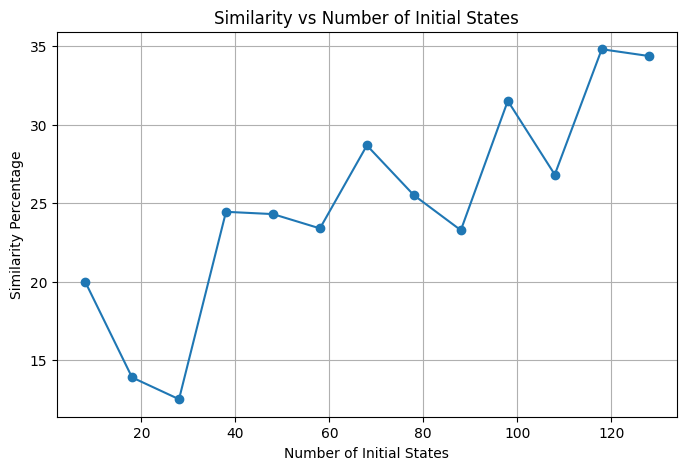

In [191]:
temp = NUM_INITIAL_STATES

similarity_percents = []
initial_states_list = []

for NUM_INITIAL_STATES in range(8, 129, 10):
    initial_states = generate_initial_states(node_names, fixed_nodes, num_samples=NUM_INITIAL_STATES)

    rules_dict = load_rules(INPUT_MODELS_DIR + "/input3.txt")

    symbols, update_funcs = prepare_symbols_and_functions(rules_dict)

    run_simulations(
        initial_states,
        INPUT_STATE_TRANSITIONS_DIR + "/st3.csv",
        node_names,
        node2idx,
        symbols,
        fixed_nodes,
        update_funcs
    )

    infer_boolean_network_mibni(
        input_csv_path = INPUT_STATE_TRANSITIONS_DIR + "/st3.csv",
        output_txt_path = OUTPUT_MODELS_DIR + "/output3.txt",
        node_names = node_names
    )

    rules_dict = load_rules(OUTPUT_MODELS_DIR + "/output3.txt")

    symbols, update_funcs = prepare_symbols_and_functions(rules_dict)

    initial_states2 = generate_initial_states(node_names, fixed_nodes, num_samples=NUM_INITIAL_STATES)

    run_simulations(
        initial_states2,
        OUTPUT_STATE_TRANSITIONS_DIR + "/st3.csv",
        node_names,
        node2idx,
        symbols,
        fixed_nodes,
        update_funcs
    )

    similarity_percent = compare_transition_files(INPUT_STATE_TRANSITIONS_DIR + "/st3.csv", OUTPUT_STATE_TRANSITIONS_DIR + "/st3.csv")
    
    # Save the results
    initial_states_list.append(NUM_INITIAL_STATES)
    similarity_percents.append(similarity_percent)

# Now plot
plt.figure(figsize=(8, 5))
plt.plot(initial_states_list, similarity_percents, marker='o')
plt.xlabel('Number of Initial States')
plt.ylabel('Similarity Percentage')
plt.title('Similarity vs Number of Initial States')
plt.grid(True)
plt.show()

NUM_INITIAL_STATES = temp

In [192]:
import builtins

class suppress_prints:
    """
    Context manager that silences all calls to builtins.print()
    (and can be extended to silence IPython.display if needed).
    """
    def __enter__(self):
        self._orig_print = builtins.print
        builtins.print = lambda *args, **kwargs: None

    def __exit__(self, exc_type, exc_val, exc_tb):
        builtins.print = self._orig_print


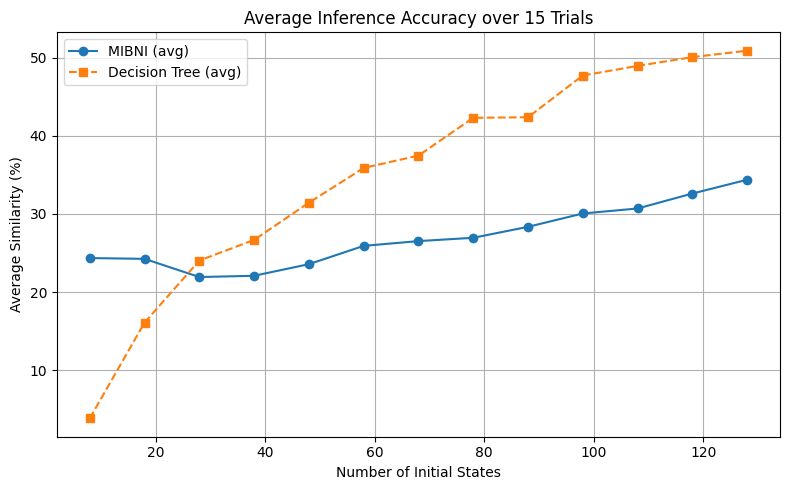

In [193]:
import matplotlib.pyplot as plt
import numpy as np
from contextlib import contextmanager
import sys
import os

# suppress_prints() context manager
@contextmanager
def suppress_prints():
    with open(os.devnull, 'w') as devnull:
        old_stdout, old_stderr = sys.stdout, sys.stderr
        try:
            sys.stdout = sys.stderr = devnull
            yield
        finally:
            sys.stdout, sys.stderr = old_stdout, old_stderr

# Save original global value if needed
try:
    temp = NUM_INITIAL_STATES
except NameError:
    temp = None

# Parameters
num_trials = 15  # Number of trials per setting
initial_states_range = list(range(8, 129, 10))

initial_states_list = []
mibni_similarities_avg = []
dt_similarities_avg    = []

with suppress_prints():
    for NUM_INITIAL_STATES in initial_states_range:
        initial_states_list.append(NUM_INITIAL_STATES)

        mibni_scores = []
        dt_scores    = []

        for _ in range(num_trials):
            # === MIBNI ===
            init1 = generate_initial_states(node_names, fixed_nodes, NUM_INITIAL_STATES)
            init2 = generate_initial_states(node_names, fixed_nodes, NUM_INITIAL_STATES)

            rules_dict = load_rules(INPUT_MODELS_DIR + "/input3.txt")

            symbols, update_funcs = prepare_symbols_and_functions(rules_dict)

            run_simulations(init1,
                            INPUT_STATE_TRANSITIONS_DIR + "/st3.csv",
                            node_names, node2idx, symbols, fixed_nodes, update_funcs)

            infer_boolean_network_mibni(
                input_csv_path  = INPUT_STATE_TRANSITIONS_DIR + "/st3.csv",
                output_txt_path = OUTPUT_MODELS_DIR + "/output3.txt",
                node_names      = node_names
            )

            rules_dict = load_rules(OUTPUT_MODELS_DIR + "/output3.txt")

            symbols, update_funcs = prepare_symbols_and_functions(rules_dict)

            run_simulations(init2,
                            OUTPUT_STATE_TRANSITIONS_DIR + "/st3.csv",
                            node_names, node2idx, symbols, fixed_nodes, update_funcs)

            similarity_mibni = compare_transition_files(
                INPUT_STATE_TRANSITIONS_DIR  + "/st3.csv",
                OUTPUT_STATE_TRANSITIONS_DIR + "/st3.csv"
            )
            mibni_scores.append(similarity_mibni)

            # === Decision Tree ===
            init3 = generate_initial_states(node_names, fixed_nodes, NUM_INITIAL_STATES)
            init4 = generate_initial_states(node_names, fixed_nodes, NUM_INITIAL_STATES)

            rules_dict = load_rules(INPUT_MODELS_DIR + "/input3.txt")

            symbols, update_funcs = prepare_symbols_and_functions(rules_dict)

            run_simulations(init3,
                            INPUT_STATE_TRANSITIONS_DIR + "/st3.csv",
                            node_names, node2idx, symbols, fixed_nodes, update_funcs)

            infer_boolean_network(
                input_csv_path  = INPUT_STATE_TRANSITIONS_DIR + "/st3.csv",
                output_txt_path = OUTPUT_MODELS_DIR + "/output3.txt",
                node_names      = node_names
            )

            rules_dict = load_rules(OUTPUT_MODELS_DIR + "/output3.txt")

            symbols, update_funcs = prepare_symbols_and_functions(rules_dict)

            run_simulations(init4,
                            OUTPUT_STATE_TRANSITIONS_DIR + "/st3.csv",
                            node_names, node2idx, symbols, fixed_nodes, update_funcs)

            similarity_dt = compare_transition_files(
                INPUT_STATE_TRANSITIONS_DIR  + "/st3.csv",
                OUTPUT_STATE_TRANSITIONS_DIR + "/st3.csv"
            )
            dt_scores.append(similarity_dt)

        # Take averages
        mibni_similarities_avg.append(np.mean(mibni_scores))
        dt_similarities_avg.append(np.mean(dt_scores))

# Restore original value
if temp is not None:
    NUM_INITIAL_STATES = temp

# Plot
plt.figure(figsize=(8, 5))
plt.plot(initial_states_list, mibni_similarities_avg, marker='o', linestyle='-', label='MIBNI (avg)')
plt.plot(initial_states_list, dt_similarities_avg,    marker='s', linestyle='--', label='Decision Tree (avg)')
plt.xlabel('Number of Initial States')
plt.ylabel('Average Similarity (%)')
plt.title(f'Average Inference Accuracy over {num_trials} Trials')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


### Components of Loss Function

In [231]:
def average_sensitivity(f):
    """
    Compute the exact average sensitivity of a Boolean function f.
    Reference: Shmulevich & Kauffman, "Activities and sensitivities in Boolean network models," PRL (2004).
    """
    n = int(np.log2(len(f)))
    total = 0
    for x in itertools.product([0, 1], repeat=n):
        idx = sum([x[n-1-i] << i for i in range(n)])
        for i in range(n):
            y = list(x)
            y[i] ^= 1
            jdx = sum([y[n-1-k] << k for k in range(n)])
            total += abs(f[idx] - f[jdx])
    return total / (n * 2**n)

def input_redundancy(f):
    """
    Compute input redundancy as 1 - effective connectivity.
    Effective connectivity is the number of relevant inputs.
    Reference: Shmulevich et al., "The role of certain Boolean functions in Boolean network models of genetic regulatory networks," PNAS (2002).
    """
    n = int(np.log2(len(f)))
    relevant_inputs = 0
    for i in range(n):
        different = False
        for x in itertools.product([0, 1], repeat=n):
            idx = sum([x[n-1-j] << j for j in range(n)])
            y = list(x)
            y[i] ^= 1
            jdx = sum([y[n-1-j] << j for j in range(n)])
            if f[idx] != f[jdx]:
                different = True
                break
        if different:
            relevant_inputs += 1
    return 1 - (relevant_inputs / n)

def compute_scores(F, I, constants):
    scores = {}

    # Average Canalization Depth
    canalization_depths = [cft.find_layers(f)[0] for f in F]
    scores['average_canalization_depth'] = np.mean(canalization_depths)
    scores['number of nodes'] = len(canalization_depths)

    # Redundancy (input redundancy)
    redundancies = [input_redundancy(f) for f in F]
    scores['average_redundancy'] = np.mean(redundancies)

    # Average Sensitivity
    sensitivities = [average_sensitivity(f) for f in F]
    scores['average_sensitivity'] = np.mean(sensitivities)

    # Create graph from adjacency matrix using toolbox function
    A = cft.adjacency_matrix(I, constants)
    G = nx.from_numpy_array(A, create_using=nx.DiGraph)

    # Feed-Forward Loops (FFLs)
    ffls, ffl_types = cft.get_ffls(A, F, I)
    scores['number_of_ffls'] = len(ffls)/len(canalization_depths)

    # Feedback Loops (FBLs)
    scores['number_of_fbls'] = sum(1 for cycle in nx.simple_cycles(G) if len(cycle) > 1)/len(canalization_depths)

    # Criticality (Derrida value)
    scores['criticality'] = cft.derrida_value(F, I, len(F), 1)

    return scores

folder_path = INPUT_MODELS_DIR
    
# Loop over all .txt files in the folder
for filename in sorted(os.listdir(folder_path)):
    if filename.endswith('.txt'):
        file_path = os.path.join(folder_path, filename)
        
        # Load the Boolean network from the current file
        F, I, degree, variables, constants = db.text_to_BN(folder='', textfile=file_path)
        
        # Compute scores
        scores = compute_scores(F, I, constants)
        
        # Output scores with filename as header
        print(f"\n--- Scores for {filename} ---")
        for metric, value in scores.items():
            print(f"{metric}: {value:.4f}")


--- Scores for input1.txt ---
average_canalization_depth: 1.8293
number of nodes: 41.0000
average_redundancy: 0.0000
average_sensitivity: 0.7282
number_of_ffls: 0.4146
number_of_fbls: 2.9024
criticality: 1.0000

--- Scores for input2.txt ---
average_canalization_depth: 1.8571
number of nodes: 7.0000
average_redundancy: 0.0000
average_sensitivity: 0.5714
number_of_ffls: 0.0000
number_of_fbls: 1.5714
criticality: 0.9060

--- Scores for input3.txt ---
average_canalization_depth: 0.8571
number of nodes: 7.0000
average_redundancy: 0.0000
average_sensitivity: 0.3589
number_of_ffls: 9.2857
number_of_fbls: 41.1429
criticality: 1.3120


### Simulated Annealing

In [244]:
import random, re
import sympy as sp
from sympy.logic.boolalg import simplify_logic

# === Parse Boolean model into dictionary ===
def parse_boolean_model(file_path):
    model = {}
    with open(file_path, 'r') as f:
        for line in f:
            line = line.strip()
            if '=' in line:
                gene, rule = line.split('=', 1)
                model[gene.strip()] = rule.strip()
    return model

# === Safely mutate Boolean rules ===
def mutate_rule(rule, node_names):
    rule = rule.strip()
    rule = re.sub(r'\s+', ' ', rule)
    rule = rule.replace('AND', ' AND ').replace('OR', ' OR ').replace('NOT', ' NOT ')
    rule = re.sub(r'\(\s*', '(', rule)
    rule = re.sub(r'\s*\)', ')', rule)

    syms = sp.symbols(node_names)
    sym_map = dict(zip(node_names, syms))

    expr_str = rule.replace('AND', '&').replace('OR', '|').replace('NOT', '~')

    try:
        expr = sp.sympify(expr_str, locals=sym_map)
    except Exception:
        return rule

    if isinstance(expr, bool):
        return rule  # skip mutation for constant expressions

    choice = random.choice(['flip_literal', 'add_literal', 'remove_literal', 'negate_all'])

    try:
        if choice == 'flip_literal':
            lits = list(expr.atoms(sp.Symbol))
            if lits:
                lit = random.choice(lits)
                expr = simplify_logic(expr ^ lit)
        elif choice == 'add_literal':
            g = random.choice(syms)
            new_lit = ~g if random.choice([True, False]) else g
            expr = simplify_logic(expr | new_lit, force=True)
        elif choice == 'remove_literal':
            dnf = simplify_logic(expr, form='dnf')
            if isinstance(dnf, sp.Or):
                clauses = list(dnf.args)
            else:
                clauses = [dnf]
            if not clauses:
                return rule
            clause_expr = random.choice(clauses)
            clause = list(clause_expr.args) if isinstance(clause_expr, sp.And) else [clause_expr]
            if clause:
                clause.pop(random.randrange(len(clause)))
            new_clause = sp.And(*clause) if len(clause) > 1 else clause[0] if clause else sp.false
            other = [c for c in clauses if c != clause_expr]
            expr = simplify_logic(sp.Or(new_clause, *other), force=True)
        else:  # negate_all
            expr = simplify_logic(~expr)
    except Exception:
        return rule

    expr = simplify_logic(expr, form='dnf')

    if isinstance(expr, bool):
        return rule  # fallback if simplification results in constant

    s = str(expr).replace('&', 'AND').replace('|', 'OR').replace('~', 'NOT ')
    s = re.sub(r'\(\s*', '(', s)
    s = re.sub(r'\s*\)', ')', s)
    s = re.sub(r'\s+', ' ', s).strip()
    return s

# === Save model to file ===
def save_model(model, path):
    with open(path, 'w') as f:
        for gene, rule in model.items():
            f.write(f"{gene} = {rule}\n")

# === Loss function ===
def loss_function(scores, baseline_scores, similarity_score):
    canalization_penalty = max(0, baseline_scores['average_canalization_depth'] - scores['average_canalization_depth'])
    ffl_penalty = max(0, baseline_scores['number_of_ffls'] - scores['number_of_ffls'])
    fbl_penalty = max(0, baseline_scores['number_of_fbls'] - scores['number_of_fbls'])

    loss = (
        abs(1 - scores['average_sensitivity']) * 1.5
        - scores['average_canalization_depth'] * 0.7
        + abs(scores['number_of_ffls'] - 1.0) * 0.2
        + abs(scores['number_of_fbls'] - 0.2) * 0.4
        + scores['criticality'] * 0.45
        - similarity_score * 0.01
    )
    return loss

# === Extract motif genes from score dictionary ===
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter

def extract_motif_genes(F, I, constants, node_names,
                        min_ffl_membership=10,
                        min_fbl_membership=11,
                        draw_graph=True):
    """
    Return the set of genes that participate in >= min_ffl_membership
    *unique* FFLs AND >= min_fbl_membership unique FBLs.
    If draw_graph=True, plot the network with those genes in red.
    """
    # Build adjacency & graph
    A = cft.adjacency_matrix(I, constants)
    G = nx.from_numpy_array(A, create_using=nx.DiGraph)

    # --- 1) Feed‐forward loops, deduped ---
    ffls, _     = cft.get_ffls(A, F, I)  
    unique_ffls = {frozenset(motif) for motif in ffls}  
    ffl_count   = Counter(idx for motif in unique_ffls for idx in motif)

    # --- 2) Feedback loops, deduped ---
    raw_cycles    = [c for c in nx.simple_cycles(G) if len(c)>1]
    unique_cycles = {frozenset(cycle) for cycle in raw_cycles}
    fbl_count     = Counter(idx for cycle in unique_cycles for idx in cycle)

    # --- 3) Select genes above (>=) both thresholds ---
    selected = set()
    for i, gene in enumerate(node_names):
        if (ffl_count.get(i,0) >= min_ffl_membership and
            fbl_count.get(i,0) >= min_fbl_membership):
            selected.add(gene)

    # --- 4) (Optional) Draw the graph ---
    if draw_graph:
        pos = nx.spring_layout(G, seed=42)
        colors = [
            'red' if node_names[i] in selected else 'blue'
            for i in range(len(node_names))
        ]
        plt.figure(figsize=(8, 6))
        nx.draw(
            G, pos,
            labels={i: node_names[i] for i in range(len(node_names))},
            node_color=colors,
            node_size=500,
            font_size=9,
            arrowsize=16
        )
        plt.title(
            f"Genes in ≥{min_ffl_membership} unique FFLs & ≥{min_fbl_membership} unique FBLs"
        )
        plt.tight_layout()
        plt.show()

    return selected




def similarity(modelopt):

    #define initial states

    initial_states = []
    with open(INPUT_STATE_TRANSITIONS_DIR + "/init3.txt", 'r') as file:
        initial_states = [line.strip() for line in file]

    rules_dict = load_rules(INPUT_MODELS_DIR + "/input3.txt")

    symbols, update_funcs = prepare_symbols_and_functions(rules_dict)

    run_simulations(
        initial_states,
        INPUT_STATE_TRANSITIONS_DIR + "/st3.csv",
        node_names,
        node2idx,
        symbols,
        fixed_nodes,
        update_funcs
    )

    if modelopt == 1:
        rules_dict = load_rules(OUTPUT_MODELS_DIR + "/output3.txt")
    else:
        rules_dict = load_rules(OUTPUT_MODELS_DIR + "/pm3.txt_temp.txt")

    symbols, update_funcs = prepare_symbols_and_functions(rules_dict)

    run_simulations(
        initial_states,
        OUTPUT_STATE_TRANSITIONS_DIR + "/st3.csv",
        node_names,
        node2idx,
        symbols,
        fixed_nodes,
        update_funcs
    )

    similarity_percent = compare_transition_files(
        INPUT_STATE_TRANSITIONS_DIR + "/st3.csv",
        OUTPUT_STATE_TRANSITIONS_DIR + "/st3.csv"
    )

    return similarity_percent

# === Guided perturbation ===
def perturb_model_loss_guided(input_path, output_path, num_steps=50, preserve_motifs=True):
    model = parse_boolean_model(input_path)
    node_names = list(model.keys())
    genes = node_names.copy()

    F, I, degree, variables, constants = db.text_to_BN(folder='', textfile=input_path)
    baseline_scores = compute_scores(F, I, constants)
    best_scores = baseline_scores.copy()

    # Include baseline similarity between input3.txt & output3.txt for init3.txt

    init_overlap = similarity(1)

    best_loss = loss_function(baseline_scores, baseline_scores, init_overlap)

    score_history = [best_scores]
    loss_history = [best_loss]
    overlap_history = [init_overlap]

    motif_genes = extract_motif_genes(F, I, constants, node_names) if preserve_motifs else set()

    for step in range(num_steps):
        candidate_genes = [g for g in genes if g not in motif_genes] if preserve_motifs else genes
        if not candidate_genes:
            print("No non-motif genes available for mutation.")
            break

        target_gene = random.choice(candidate_genes)
        original_rule = model[target_gene]

        new_rule = mutate_rule(original_rule, node_names)
        if new_rule == original_rule:
            continue

        model[target_gene] = new_rule
        temp_path = output_path + "_temp.txt"
        save_model(model, temp_path)

        try:
            F_new, I_new, degree_new, variables_new, constants_new = db.text_to_BN(folder='', textfile=temp_path)
            new_scores = compute_scores(F_new, I_new, constants_new)

            # include new similarity between input3.txt and pm3.txt_temp.txt for init.txt

            cur_similarity = similarity(0)
            new_loss = loss_function(new_scores, baseline_scores, cur_similarity)
        except Exception as e:
            print(f"Step {step+1}: Error in recomputation ({e}), skipping.")
            model[target_gene] = original_rule
            continue

        loss_history.append(new_loss)

        if new_loss <= best_loss:
            best_loss = new_loss
            best_scores = new_scores
            score_history.append(new_scores.copy())
            overlap_history.append(cur_similarity)
            print(f"Step {step+1}: ✅ Accepted (loss = {best_loss:.4f})")
        else:
            model[target_gene] = original_rule
            print(f"Step {step+1}: ❌ Rejected")

    save_model(model, output_path)
    return model, score_history, loss_history, overlap_history


Run 1/60: steady state | steps = 2, cycle_length = 1
Run 2/60: steady state | steps = 3, cycle_length = 1
Run 3/60: steady state | steps = 2, cycle_length = 1
Run 4/60: steady state | steps = 2, cycle_length = 1
Run 5/60: steady state | steps = 5, cycle_length = 1
Run 6/60: steady state | steps = 8, cycle_length = 1
Run 7/60: steady state | steps = 5, cycle_length = 1
Run 8/60: steady state | steps = 6, cycle_length = 1
Run 9/60: steady state | steps = 4, cycle_length = 1
Run 10/60: steady state | steps = 7, cycle_length = 1
Run 11/60: steady state | steps = 8, cycle_length = 1
Run 12/60: steady state | steps = 9, cycle_length = 1
Run 13/60: steady state | steps = 7, cycle_length = 1
Run 14/60: steady state | steps = 7, cycle_length = 1
Run 15/60: steady state | steps = 5, cycle_length = 1
Run 16/60: limit cycle | steps = 3, cycle_length = 2
Run 17/60: steady state | steps = 5, cycle_length = 1
Run 18/60: steady state | steps = 7, cycle_length = 1
Run 19/60: steady state | steps = 2, c

/tmp/ipykernel_9901/2184109347.py:156: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


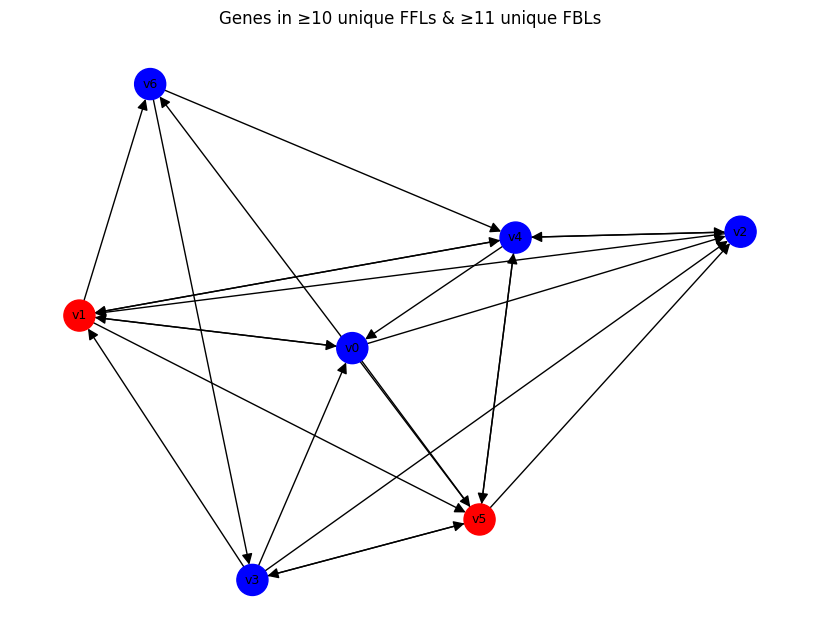

Run 1/60: steady state | steps = 2, cycle_length = 1
Run 2/60: steady state | steps = 2, cycle_length = 1
Run 3/60: steady state | steps = 3, cycle_length = 1
Run 4/60: steady state | steps = 2, cycle_length = 1
Run 5/60: steady state | steps = 5, cycle_length = 1
Run 6/60: steady state | steps = 5, cycle_length = 1
Run 7/60: steady state | steps = 4, cycle_length = 1
Run 8/60: steady state | steps = 5, cycle_length = 1
Run 9/60: steady state | steps = 8, cycle_length = 1
Run 10/60: steady state | steps = 5, cycle_length = 1
Run 11/60: steady state | steps = 7, cycle_length = 1
Run 12/60: steady state | steps = 7, cycle_length = 1
Run 13/60: steady state | steps = 9, cycle_length = 1
Run 14/60: steady state | steps = 8, cycle_length = 1
Run 15/60: steady state | steps = 6, cycle_length = 1
Run 16/60: steady state | steps = 7, cycle_length = 1
Run 17/60: steady state | steps = 7, cycle_length = 1
Run 18/60: steady state | steps = 10, cycle_length = 1
Run 19/60: steady state | steps = 4,

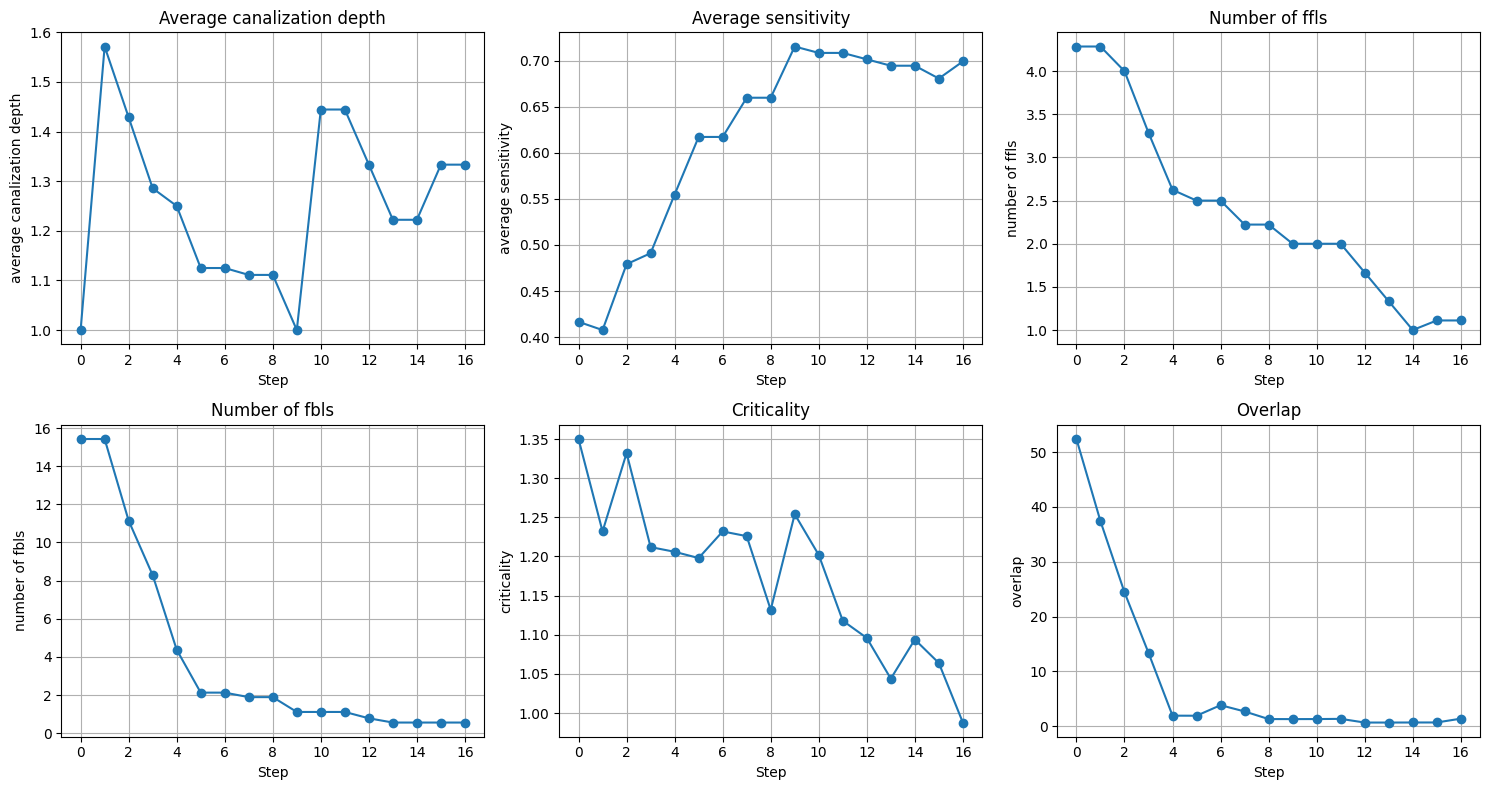

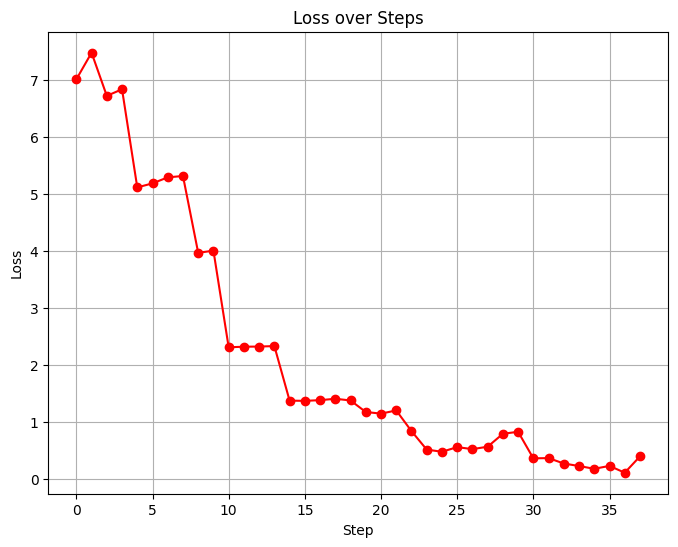

In [245]:
import matplotlib.pyplot as plt

# Run perturbation
perturbed_model, score_history, loss_history, overlap_history = perturb_model_loss_guided(
    input_path=OUTPUT_MODELS_DIR + "/output3.txt",
    output_path=OUTPUT_MODELS_DIR + "/pm3.txt",
    num_steps=50
)

# Identify all metrics, but exclude these two
exclude_metrics = {"average_redundancy", "number of nodes"}
all_metrics = list(score_history[0].keys())

print(all_metrics)

metrics = [m for m in all_metrics if m not in exclude_metrics]

# Determine subplot grid size automatically
n = len(metrics)
cols = 3
rows = (n + cols - 1) // cols

plt.figure(figsize=(5*cols, 4*rows))
plot_idx = 1
for metric in metrics:
    plt.subplot(rows, cols, plot_idx)
    values = [scores[metric] for scores in score_history]
    plt.plot(values, marker='o')
    plt.title(metric.replace('_', ' ').capitalize())
    plt.xlabel('Step')
    plt.ylabel(metric.replace('_', ' '))
    plt.grid(True)
    plot_idx += 1

plt.subplot(rows, cols, plot_idx)
values = [scores for scores in overlap_history]
plt.plot(values, marker='o')
plt.title("overlap".replace('_', ' ').capitalize())
plt.xlabel('Step')
plt.ylabel("overlap".replace('_', ' '))
plt.grid(True)
plot_idx += 1

plt.tight_layout()
plt.show()

# Plotting the loss curve
plt.figure(figsize=(8, 6))
plt.plot(loss_history, marker='o', color='red')
plt.title('Loss over Steps')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.grid(True)
plt.show()
